# SILVA-CRAS SEPPO

# Capitulo 3 - Detección de cambio con métricas de series de tiempo y el método Log Ratio

Josef Kellndorfer, Ph.D., President and Senior Scientist, Earth Big Data, LLC

Carlos Pedraza, Ms.C., Spatial analyst and Monitoring Expert, iScioLab and Earth Big Data, LLC

Fecha revisión: Pendiente

En este capítulo se presentan cuatro métdoso para la detección de cambio de deforestación basados en:

- Métricas de series de tiempo de diferencias de umbrales en los percentiles 95$^{th}$ and 5$^{th}$
- Umbral definido por el coeficiente de variación (COV) a partir de series de tiempo
- Log Ratio a partir de dos páres de imágenes
- Cambio anual en el coeficiente de variación

# Import Python modules

In [10]:
import os,sys,gdal
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.patches as patches  # Needed to draw rectangles
from skimage import exposure # to enhance image display
import numpy as np
import pandas as pd

# Select the Project data set and time series data

In [ ]:
# # SENTINEL-1 TIME SERIES STACK VV from LOUISIANA FOREST MANAGEMENT SITE
# datapath='/dev/shm/projects/c303nisar/louisiana/15SWRsS1/15SWRsS1-EBD/'
# imagefile='15SWRsS1_A_vv_0063_A_mtfil.vrt'
# datefile='15SWRsS1_A_vv_0063_A_mtfil.dates'


In [ ]:
datadirectory='/Users/amenaza/github/Silva-Cras-PatNat/Data/Colombia/S32718X350000Y9353000sS1_EBD/'
datefile_like=  'S32718X350000Y9323000sS1_A_vv_mtfil.dates'
datefile_cross= 'S32718X350000Y9323000sS1_A_vh_mtfil.dates'
imagefile_like= 'S32718X350000Y9323000sS1_A_vv_mtfil.vrt'
imagefile_cross='S32718X350000Y9323000sS1_A_vh_mtfil.vrt'
subset=None
# For Descending Example choose Cross Pol, for Ascending Like-pol
imagefile=imagefile_like
datefile=datefile_like

## Colombia MGRS Tile 18NWF

In [11]:
datadirectory='/Users/amenaza/github/Silva-Cras-PatNat/Data/Colombia/S32618X557000Y64000sS1_EBD'
datefile_like='S32618X557000Y64000sS1_D_vv_0069_mtfil.dates'
imagefile_like='S32618X557000Y64000sS1_D_vv_0069_mtfil.vrt'
datefile_cross='S32618X557000Y64000sS1_D_vh_0069_mtfil.dates'
imagefile_cross='S32618X557000Y64000sS1_D_vh_0069_mtfil.vrt'
subset=None
# For Descending Example choose Cross Pol, for Ascending Like-pol
imagefile=imagefile_like
datefile=datefile_like

In [12]:
os.chdir(datadirectory)

We are defining two helper functions for this task

- **CreateGeoTiff()** to write out images
- **timeseries_metrics()** to compute various metrics from a time series data stack

In [13]:
def CreateGeoTiff(Name, Array, DataType, NDV,bandnames=None,ref_image=None, 
                  GeoT=None, Projection=None):
    # If it's a 2D image we fake a third dimension:
    if len(Array.shape)==2:
        Array=np.array([Array])
    if ref_image==None and (GeoT==None or Projection==None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != Array.shape[0]:
            raise RuntimeError('Need {} bandnames. {} given'
                               .format(Array.shape[0],len(bandnames)))
    else:
        bandnames=['Band {}'.format(i+1) for i in range(Array.shape[0])]
    if ref_image!= None:
        refimg=gdal.Open(ref_image)
        GeoT=refimg.GetGeoTransform()
        Projection=refimg.GetProjection()
    driver= gdal.GetDriverByName('GTIFF')
    Array[np.isnan(Array)] = NDV
    DataSet = driver.Create(Name, 
            Array.shape[2], Array.shape[1], Array.shape[0], DataType,options=['PHOTOMETRIC=RGB'])
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection( Projection)
    for i, image in enumerate(Array, 1):
        band=DataSet.GetRasterBand(i)
        band.SetNoDataValue(NDV)
        band.SetDescription(bandnames[i-1])
        band.WriteArray( image )
    DataSet.FlushCache()
    DataSet=None
    return Name

In [14]:
def timeseries_metrics(raster,ndv=0): 
    # Make us of numpy nan functions
    # Check if type is a float array
    if not raster.dtype.name.find('float')>-1:
        raster=raster.astype(np.float32)
    # Set ndv to nan
    if ndv != np.nan:
        raster[np.equal(raster,ndv)]=np.nan
    # Build dictionary of the metrics
    tsmetrics={}
    rperc = np.nanpercentile(raster,[5,50,95],axis=0)
    tsmetrics['mean']=np.nanmean(raster,axis=0)
    tsmetrics['max']=np.nanmax(raster,axis=0)
    tsmetrics['min']=np.nanmin(raster,axis=0)
    tsmetrics['range']=tsmetrics['max']-tsmetrics['min']
    tsmetrics['median']=rperc[1]
    tsmetrics['p5']=rperc[0]
    tsmetrics['p95']=rperc[2]
    tsmetrics['prange']=rperc[2]-rperc[0]
    tsmetrics['var']=np.nanvar(raster,axis=0)
    tsmetrics['cov']=tsmetrics['var']/tsmetrics['mean']
    return tsmetrics

## Set the Dates

In [15]:
# Get the date indices via pandas
dates=open(datefile).readlines()
tindex=pd.DatetimeIndex(dates)
tindexOrg=tindex
j=1
print('Bands and dates for',imagefile)
for i in tindex:
    print("{:4d} {}".format(j, i.date()),end=' ')
    j+=1
    if j%5==1: print()

Bands and dates for S32618X557000Y64000sS1_D_vv_0069_mtfil.vrt
   1 2017-01-21    2 2017-02-14    3 2017-04-03    4 2017-04-15    5 2017-04-27 
   6 2017-05-09    7 2017-05-21    8 2017-06-02    9 2017-06-14   10 2017-06-26 
  11 2017-07-08   12 2017-07-20   13 2017-08-01   14 2017-08-13   15 2017-08-25 
  16 2017-09-06   17 2017-09-18   18 2017-09-30   19 2017-10-12   20 2017-10-24 
  21 2017-11-05   22 2017-11-17   23 2017-11-29   24 2017-12-11   25 2017-12-23 
  26 2018-01-04   27 2018-01-16   28 2018-01-28   29 2018-02-09   30 2018-02-21 
  31 2018-03-05   32 2018-03-17   33 2018-03-29   34 2018-04-10   35 2018-04-22 
  36 2018-05-04   37 2018-05-16   38 2018-05-28   39 2018-06-09   40 2018-10-31 
  41 2018-11-12   42 2018-11-24   43 2018-12-06   44 2018-12-18   45 2018-12-30 
  46 2019-01-11   47 2019-01-23   48 2019-02-04   49 2019-02-16   50 2019-03-12 
  51 2019-03-24   52 2019-04-17   53 2019-04-29   54 2019-05-11   55 2019-05-23 
  56 2019-06-04   57 2019-06-16   58 2019-06-2

## Explore the Images

Below are a couple of plots showing the data set

Open the image and get dimensions (bands,lines,pixels):

In [16]:
img=gdal.Open(imagefile)
img.RasterCount,img.RasterYSize,img.RasterXSize

(64, 1500, 1500)

For a managable size for this notebook we choose a 1000x1000 pixel subset to read the entire data stack. We also convert the amplitude data to power data right away and will perform the rest of the calculations on the power data to be mathmatically correct. NOTE: Choose a different xsize/ysize in the subset if you need to.

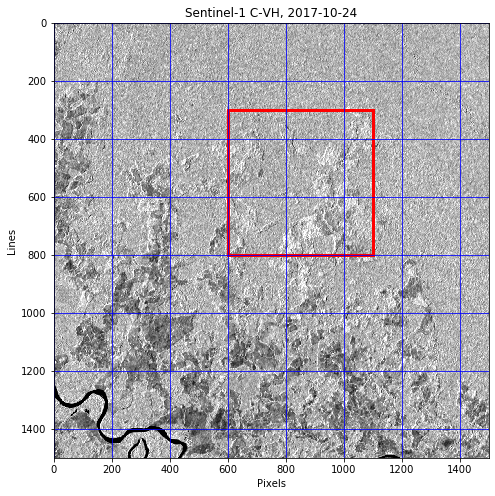

In [17]:
subset=(600,300,500,500)   # (xoff,yoff,xsize,ysize)
bandnbr=20

rasterDN=img.GetRasterBand(bandnbr).ReadAsArray()
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Sentinel-1 C-VH, {}'
             .format(tindex[bandnbr-1].date()))
ax.imshow(rasterDN,cmap='gray',vmin=2500,vmax=9000)
ax.grid(color='blue')
ax.set_xlabel('Pixels')
ax.set_ylabel('Lines')
# plot the subset as rectangle
if subset != None:
    _=ax.add_patch(patches.Rectangle((subset[0],subset[1]),
                                     subset[2],subset[3],
                                     fill=False,edgecolor='red',
                                     linewidth=3))

In [18]:
rasterDN=img.ReadAsArray(*subset)
# Filter out "black bands" in Descending data (see Notebook EBD_SAR2)
rasterDN=np.vstack((rasterDN[:2],rasterDN[6:]))
tindex=tindexOrg[:2].append(tindexOrg[6:])
mask = rasterDN==0
CF=np.power(10.,-8.3)
rasterPwr=np.ma.array(np.power(rasterDN,2.)*CF,mask=mask,dtype=np.float32)
# Code below is an example to generate an 8bit scaled dB image
# rasterDB=(10.*np.ma.log10(rasterPwr)+31)/0.15   
# rasterDB[rasterDB<1.]=1.
# rasterDB[rasterDB>255.]=255.
# rasterDB=rasterDB.astype(np.uint8)
# rasterDB=rasterDB.filled(0)

We make an RGB stack to display the first, center, and last time step as a multi-temporal color composite.
The np.dstack results in an array of the form [lines,pixels,bands], which is the format we need for RGB display with matplotlib's imshow() function. Note that numpy array indexing starts with 0, so band 1 is raster[0]. 

In [19]:
rgb_bands=(1,int(rasterDN.shape[0]/2),rasterDN.shape[0])  # first, center, last band
rgb_bands=(5,20,40) 
# rgb_bands=(18,45,74)
rgb_idx=np.array(rgb_bands)-1  # get array index from bands by subtracting 1
rgb=np.dstack((rasterPwr[rgb_idx[0]],rasterPwr[rgb_idx[1]],rasterPwr[rgb_idx[2]]))
rgb[rgb<0.0001]=0.0001
rgb[rgb>1]=1
rgb_dates=(tindex[rgb_idx[0]].date(),
           tindex[rgb_idx[1]].date(),tindex[rgb_idx[2]].date())

We are also interested in displaying the image enhanced with histogram equalization. 
We can use the function *exposure.equalize_hist()* from the skimage.exposure module

In [20]:
rgb_stretched=rgb.copy()
# For each band we apply the strech
for i in range(rgb_stretched.shape[2]):
    rgb_stretched[:,:,i] = exposure.\
    equalize_hist(rgb_stretched[:,:,i].data,
    mask=~np.equal(rgb_stretched[:,:,i].data,0.))

Now let's display the the unstrechted and histogram equalized images side by side.

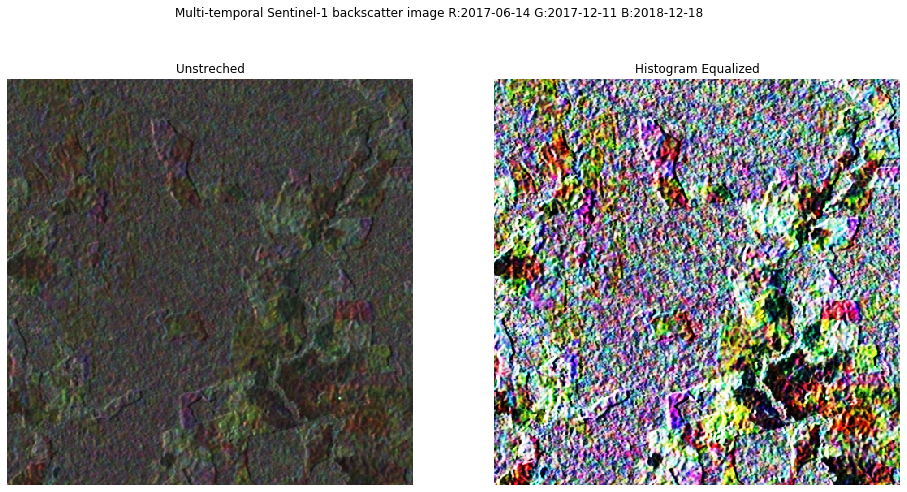

In [21]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
fig.suptitle('Multi-temporal Sentinel-1 backscatter image R:{} G:{} B:{}'
             .format(rgb_dates[0],rgb_dates[1],rgb_dates[2]))
plt.axis('off')
ax[0].imshow(rgb,vmin=0,vmax=0.15)
ax[0].set_title('Unstreched')
ax[0].axis('off')
ax[1].imshow(rgb_stretched)
ax[1].set_title('Histogram Equalized')
_=ax[1].axis('off')

# Computation and Visualization of the Time Series Metrics

For the entire time series, we will compute some metrics that will aid us in change detection. For each pixel in the stack we compute:

- Mean 
- Median
- Maximum
- Minimum
- Range (Maximum - Minimum)
- 5th Percentile
- 95th Percentile
- PRange (95th - 5th Percentile)
- Variance
- Coefficient of Variation (Variance/Mean)

In [22]:
metrics=timeseries_metrics(rasterPwr.filled(np.nan),ndv=np.nan)

In [23]:
metrics.keys()

dict_keys(['mean', 'max', 'min', 'range', 'median', 'p5', 'p95', 'prange', 'var', 'cov'])

Let's look at the histograms for the time series variance and coeficient of variation to aid displaying those images:

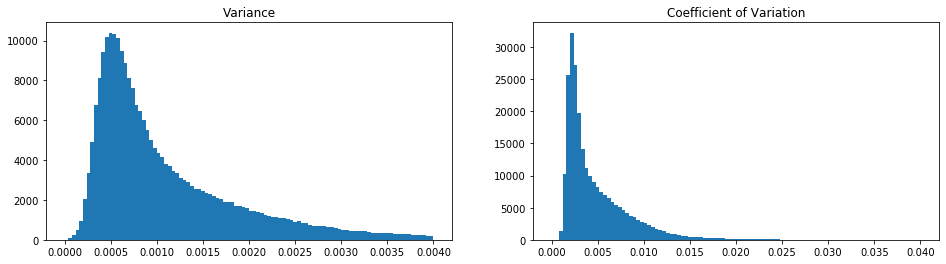

In [24]:
fig, ax= plt.subplots(1,2,figsize=(16,4))
ax[0].hist(metrics['var'].flatten(),bins=100,range=(0,0.004))
ax[1].hist(metrics['cov'].flatten(),bins=100,range=(0,0.04))
_=ax[0].set_title('Variance')
_=ax[1].set_title('Coefficient of Variation')

We use thresholds determined from those histograms to set the scaling in the time series visualiztion. For the backscatter metrics we choose a typeical range appropriate for this ecosystem and radar sensor. A typical range is -30 dB (0.0001) to -5.2 dB (0.3).

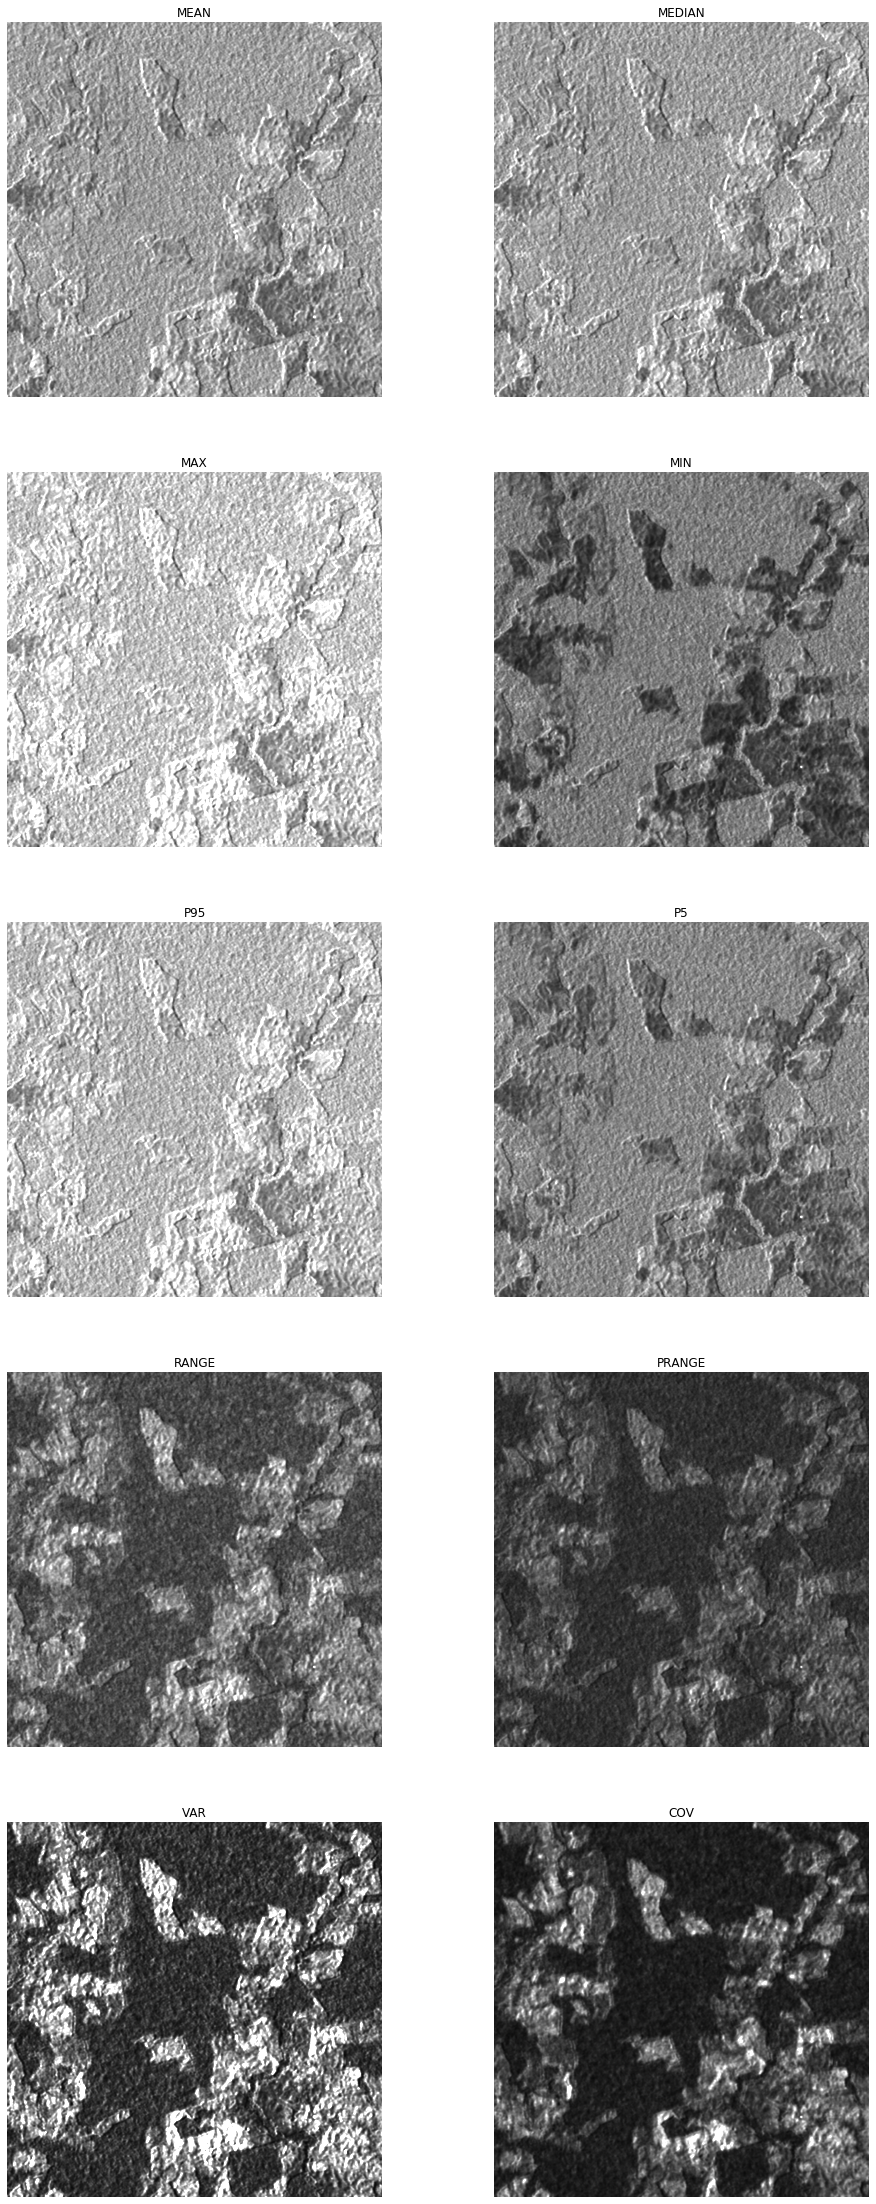

In [25]:
# List the metrics keys you want to plot
metric_keys=['mean', 'median', 'max', 'min', 
             'p95', 'p5','range', 'prange','var','cov']
fig= plt.figure(figsize=(16,40))
idx=1
for i in metric_keys:
    ax = fig.add_subplot(5,2,idx)
    if i=='var': vmin,vmax=(0.0,0.003)
    elif i == 'cov': vmin,vmax=(0.,0.02)
    else:
        vmin,vmax=(0.0001,0.4)
    ax.imshow(metrics[i],vmin=vmin,vmax=vmax,cmap='gray',interpolation='bilinear')
    ax.set_title(i.upper())
    ax.axis('off')
    idx+=1

# Change detection with the Percentile Difference Threshold Method

In this method we find thresholds on the 95$^{th}$ and 5$^{th}$ percentile difference. The advantage to look at percentiles verus maximum minus minimum is that outliers and extremas in the time series are not influencing the result.

For our example, the historgram of the 95$^{th}$ and 5$^{th}$ percentile difference image looks like this:

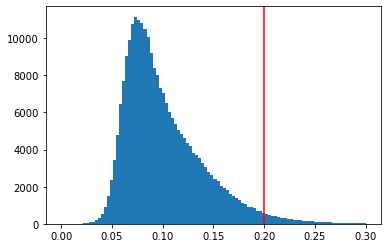

In [29]:
plt.hist(metrics['prange'].flatten(),bins=100,range=(0,0.3))
_=plt.axvline(0.2,color='red')

Let's visualize the change pixels (cp) where the 95th - 5th percentile difference in the time series for each pixel (x,y) exceed a threshold $t$

${cp}_{x,y} = P_{x,y}^{95th} - P_{x,y}^{5th} > t$ 

With $t=0.2$ the image looks like:

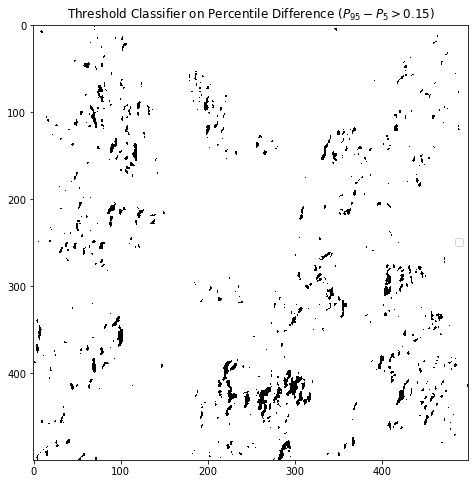

In [35]:
thres=0.2
plt.figure(figsize=(8,8))
mask=metrics['prange']<thres # For display we prepare the inverse mask
maskpdiff=~mask # Store this for later output
plt.imshow(mask,cmap='gray')
plt.legend(['$p_{95} - p_5 > 0.15$'],loc='center right')
_=plt.title('Threshold Classifier on Percentile Difference ($P_{95} - P_5 > 0.15$)')

# Change Detection with the Coefficient of Variation Method

We can set a threshold $t$ for the coefficient of variation image
to classify change in the time series:
    
${cp}_{x,y} = \frac{\sigma_{x,y}^2}{\overline{X}_{x,y}} > t$ 

Let's look at the histogram of the coefficient of variation:

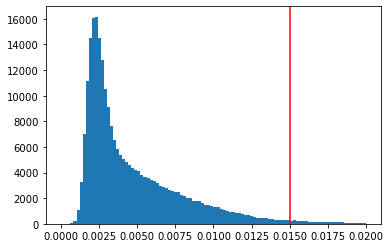

In [36]:
plt.hist(metrics['cov'].flatten(),bins=100,range=(0,0.02))
_=plt.axvline(0.015,color='red')

With a threshold t=0.015 the change pixels would look like the following image:


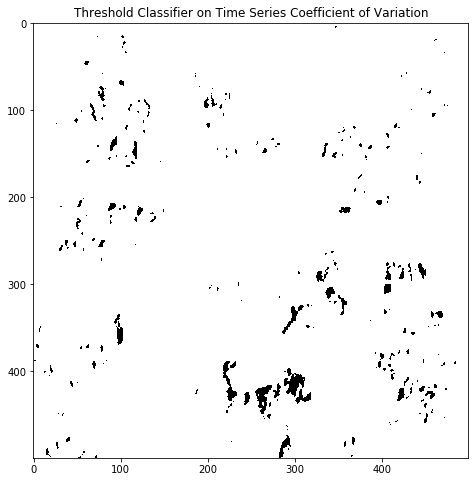

In [37]:
thres=0.015
mask=metrics['cov'] < thres
maskcv=~mask
plt.figure(figsize=(8,8))
plt.imshow(mask,cmap='gray')
_=plt.title('Threshold Classifier on Time Series Coefficient of Variation')

In [38]:
print(tindex[0],tindex[-1])

2017-01-21 00:00:00 2019-09-08 00:00:00


# Change Detection with the Log Ratio Method

We compare two images from the same season in different years. First we look at global means of the backscatter images in the subset building a time series object of acquisition dates and global image means of backscatter.

In [39]:
tsmean=10*np.log10(np.nanmean(rasterPwr.filled(np.nan),axis=(1,2)))

We make a time series object to list the dates, mean backscatter in dB and band index number for the rasterPwr array:

In [40]:
ts = pd.Series(tsmean,index=tindex)
for i in range(len(ts)):
    print(i,ts.index[i].date(),ts[i])

0 2017-01-21 -5.99189
1 2017-02-14 -6.697274
2 2017-05-21 -5.939431
3 2017-06-02 -6.3204913
4 2017-06-14 -6.0045156
5 2017-06-26 -5.627328
6 2017-07-08 -5.428673
7 2017-07-20 -5.9433417
8 2017-08-01 -6.221297
9 2017-08-13 -5.968625
10 2017-08-25 -6.0111523
11 2017-09-06 -6.1730075
12 2017-09-18 -6.136343
13 2017-09-30 -6.0076056
14 2017-10-12 -5.936547
15 2017-10-24 -5.915595
16 2017-11-05 -5.9694047
17 2017-11-17 -6.031212
18 2017-11-29 -6.0901384
19 2017-12-11 -6.13813
20 2017-12-23 -6.2998343
21 2018-01-04 -6.3300395
22 2018-01-16 -6.1772056
23 2018-01-28 -5.7900996
24 2018-02-09 -6.710982
25 2018-02-21 -7.143411
26 2018-03-05 -5.973092
27 2018-03-17 -6.4432244
28 2018-03-29 -6.1440654
29 2018-04-10 -6.0251994
30 2018-04-22 -6.055667
31 2018-05-04 -6.250786
32 2018-05-16 -6.028771
33 2018-05-28 -5.9983726
34 2018-06-09 -6.015868
35 2018-10-31 -6.137967
36 2018-11-12 -5.971518
37 2018-11-24 -6.16411
38 2018-12-06 -6.7030807
39 2018-12-18 -6.555956
40 2018-12-30 -6.6029615
41 2019-01-

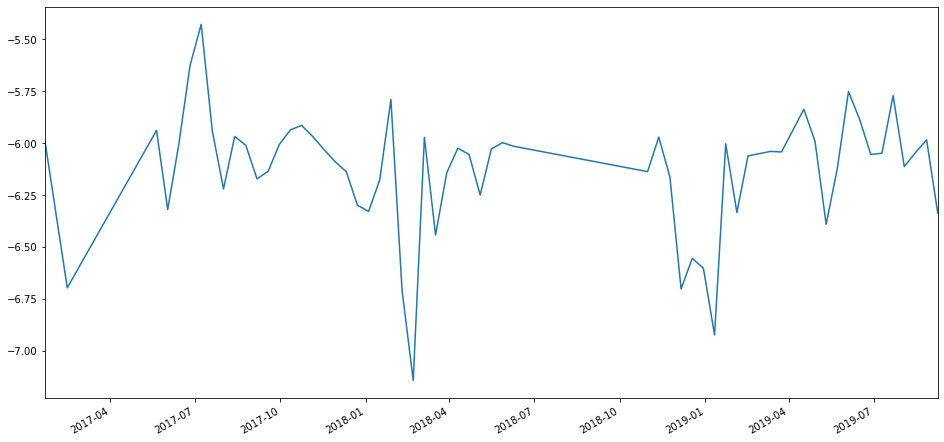

In [41]:
plt.figure(figsize=(16,8))
ts.plot()

## To compare two dates for change detection with the log ratio approach we pick two dates of relative low backscatter (dry conditions) and from similar times of the year. Two such candidate dates are

Peru Site example:

For Descending VH

- 36 2018-04-22 -12.421797
- 52 2019-04-29 -12.626116

For Ascending VV example

- 4 2017-04-18 -6.7908087
- 27 2018-04-13 -6.229033

Colombia Site example:

For Descending VH

- 24 2018-02-09 -6.8495464
- 43 2019-02-04 -6.3412642

In [42]:
# # Cross-polarized Descending
# Xr=rasterPwr[36]   # Reference Image
# Xi=rasterPwr[52]  # New Image
# Like-polarized Ascending 
Xr=rasterPwr[24]   # Reference Image
Xi=rasterPwr[43]  # New Image


The Log ratio between the images is 

$r  = log_{10}(\frac{X_i}{X_r})$

In [43]:
r = np.log10(Xi/Xr)

To find a threshold for change, we can display the absolute ration image $abs(r)$ and the historgram of $r$. We adjust the scale factors for the display to enhance visualization of change areas with largest backscatter change over the time series. Brighter values show larger change.

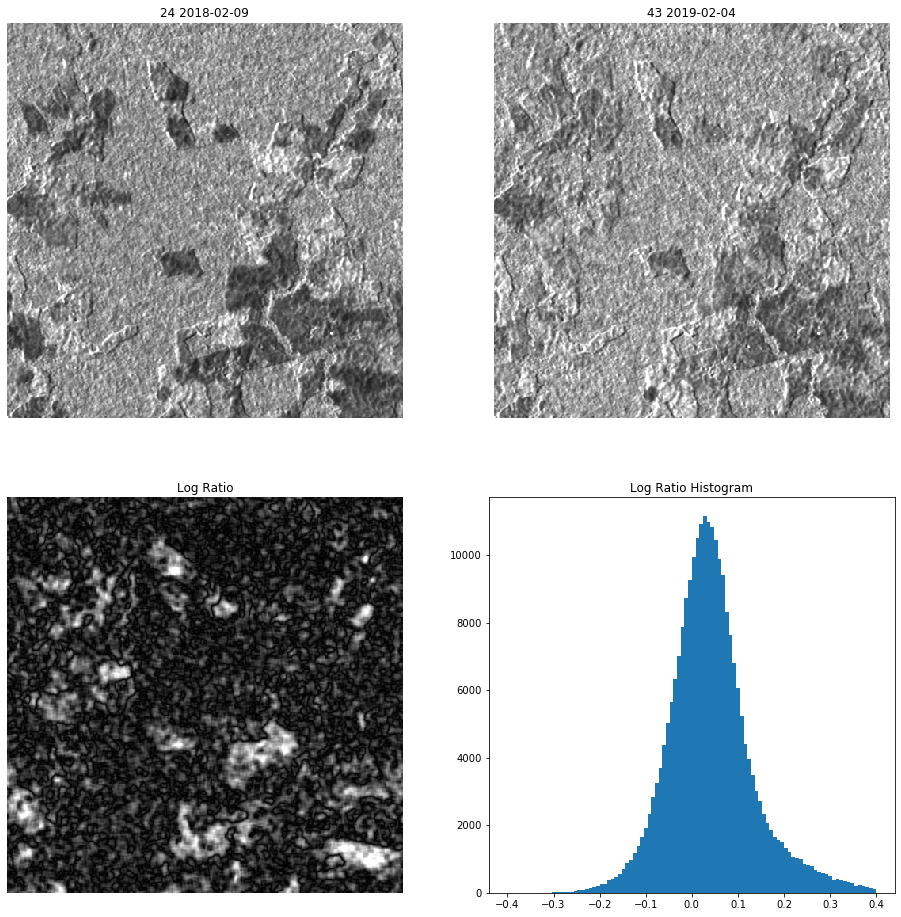

In [44]:
# Display r
fig, ax = plt.subplots(2,2,figsize=(16,16))
ax[0][0].axis('off')
ax[0][1].axis('off')
ax[1][0].axis('off')
ax[0][0].set_title('24 2018-02-09')
ax[0][0].imshow(Xr,vmin=0,vmax=0.4,cmap='gray')
ax[0][1].set_title('43 2019-02-04')
ax[0][1].imshow(Xi,vmin=0,vmax=0.4,cmap='gray')
ax[1][0].set_title('Log Ratio')
ax[1][0].imshow(np.abs(r),vmin=0,vmax=0.4,cmap='gray')
ax[1][1].set_title('Log Ratio Histogram')
_=ax[1][1].hist(r.flatten(),bins=100,range=(-0.4,0.4))

Let's define change pixels as those falling outside the range of *three* times the standard deviation of the ration image $\sigma_r$ from the image mean $\bar{r}$:

${cp}_{x,y} = (r_{x,y} < \overline{r} - 2\sigma_r) \ \textrm{or} \ (r_{x,y} > \overline{r} + 2\sigma_r)$ 

We are using the numpy masking to set the non-changing pixels inside the range:

In [45]:
stddev=np.std(r)
thres=2*stddev
mask=np.logical_and(r>-1*thres,r<thres)
masklr=~mask

Let's display pixels that fall outside 2 times the standard deviation

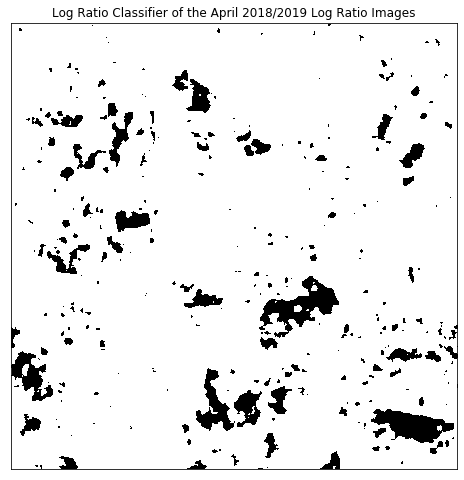

In [46]:
fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(mask,cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
_=ax.set_title('Log Ratio Classifier of the April 2018/2019 Log Ratio Images')

# Difference in time series COV between two years

Another good approach to assess change between two years is to look at the coefficient of variation between the two years and threshold a difference image of the 2

$Change =COV_{Year_2} - COV_{Year_1} > threshold$

In the cells below we compute the COVs for 2017 and 2018, look at the difference and select a threshold for change.


In [47]:
# Let's print the dates again:
print('Bands and dates for',imagefile)
j=1
for i in tindex:
    print("{:4d} {}".format(j, i.date()),end=' ')
    j+=1
    if j%5==1: print()

Bands and dates for S32618X557000Y64000sS1_D_vv_0069_mtfil.vrt
   1 2017-01-21    2 2017-02-14    3 2017-05-21    4 2017-06-02    5 2017-06-14 
   6 2017-06-26    7 2017-07-08    8 2017-07-20    9 2017-08-01   10 2017-08-13 
  11 2017-08-25   12 2017-09-06   13 2017-09-18   14 2017-09-30   15 2017-10-12 
  16 2017-10-24   17 2017-11-05   18 2017-11-17   19 2017-11-29   20 2017-12-11 
  21 2017-12-23   22 2018-01-04   23 2018-01-16   24 2018-01-28   25 2018-02-09 
  26 2018-02-21   27 2018-03-05   28 2018-03-17   29 2018-03-29   30 2018-04-10 
  31 2018-04-22   32 2018-05-04   33 2018-05-16   34 2018-05-28   35 2018-06-09 
  36 2018-10-31   37 2018-11-12   38 2018-11-24   39 2018-12-06   40 2018-12-18 
  41 2018-12-30   42 2019-01-11   43 2019-01-23   44 2019-02-04   45 2019-02-16 
  46 2019-03-12   47 2019-03-24   48 2019-04-17   49 2019-04-29   50 2019-05-11 
  51 2019-05-23   52 2019-06-04   53 2019-06-16   54 2019-06-28   55 2019-07-10 
  56 2019-07-22   57 2019-08-03   58 2019-08-1

In [48]:
# # Peru Descending VH
# idx2017=[0,27]
# idx2018=[27,47]
# Peru Ascending VV
# idx2017=[0,21]
# idx2018=[21,47]
# Colombia Descending VV
idx2017=[0,21]
idx2018=[21,41]


rp17=rasterPwr[idx2017[0]:idx2017[1]]
rp18=rasterPwr[idx2018[0]:idx2018[1]]
tsm17=timeseries_metrics(rp17)
tsm18=timeseries_metrics(rp18)

In [49]:
cov17=tsm17['cov']
cov18=tsm18['cov']

In [50]:
cov1817=cov18-cov17

Text(0.5, 1.0, 'Coefficient of Variation 2018-2017')

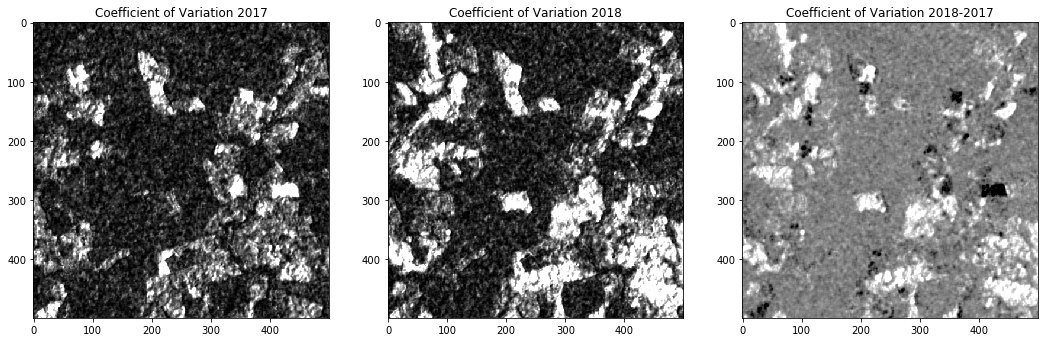

In [51]:
fig,ax=plt.subplots(1,3,figsize=(18,6))
ax[0].imshow(cov17  ,cmap='gray',vmin=0.001,vmax=0.01)
ax[1].imshow(cov18  ,cmap='gray',vmin=0.001,vmax=0.01)

# ax[0].imshow(cov17  ,cmap='gray',vmin=0.01,vmax=0.1)
# ax[1].imshow(cov18  ,cmap='gray',vmin=0.01,vmax=0.1)

ax[2].imshow(cov1817,cmap='gray',vmin=-0.01,vmax=0.01)
ax[0].set_title('Coefficient of Variation 2017')
ax[1].set_title('Coefficient of Variation 2018')
ax[2].set_title('Coefficient of Variation 2018-2017')

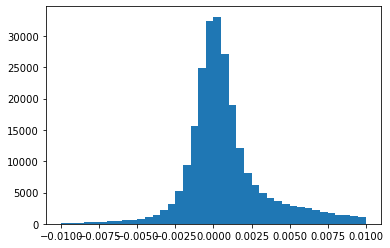

In [52]:
_=plt.hist(cov1817.flatten(),range=(-0.01,0.01), bins=40)

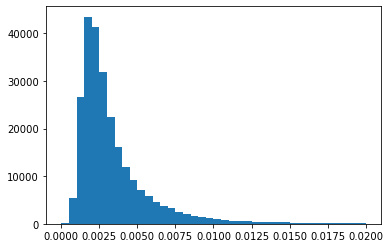

In [53]:
_=plt.hist(cov17.flatten(),range=(0,0.02), bins=40)

From the histograms abvove we can visually set two mask thresholds. One threshold is picked for low COV in 2017, i.e. leaving those classes that don't change backscatter much during the year like forests or urban areas. We could consider applying this threshold like building a simple forest and urban mask. The other threshold is picked for areas where the COV difference was high. By combining the two thresholds, we would identify where change happened under the "forest/urban mask".

Produce a "Forest/Urban" mask from low COV values in 2017: 

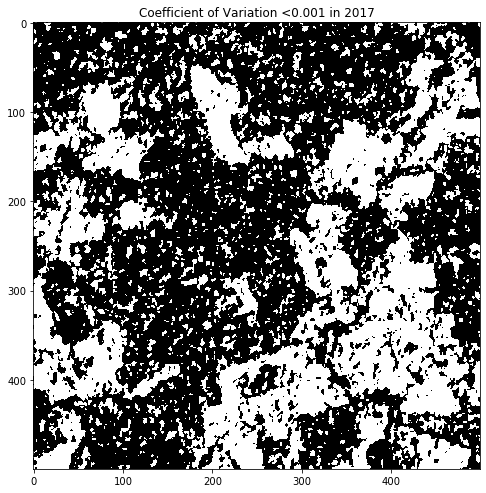

In [54]:
mask=cov17<0.003

# mask=cov17<0.0025

mask17=mask
fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(~mask  ,cmap='gray')
_=ax.set_title('Coefficient of Variation <0.001 in 2017')

Produce a mask where the COV has increased from 2017 to 2018:

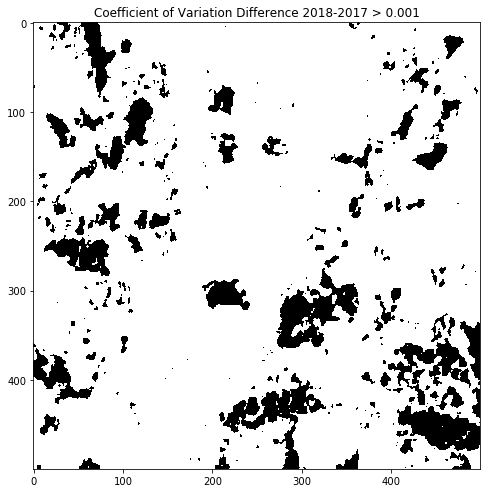

In [55]:
mask=cov1817>0.004

# mask=cov1817>0.001

maskcv1817=mask

fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(~mask  ,cmap='gray')
_=ax.set_title('Coefficient of Variation Difference 2018-2017 > 0.001')

Combine the masks:

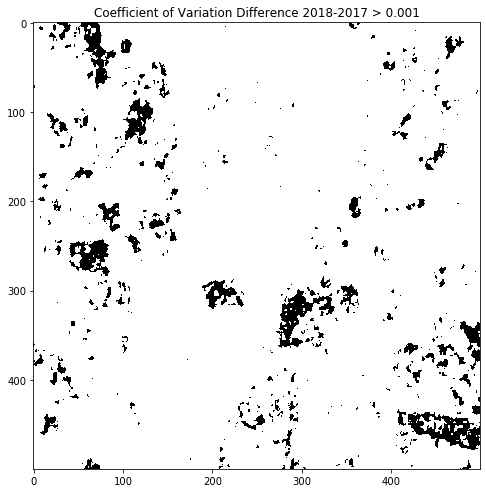

In [56]:
maskcv1817and17=mask17 & maskcv1817
fig,ax = plt.subplots(figsize=(8,16))
ax.imshow(~maskcv1817and17  ,cmap='gray')
_=ax.set_title('Coefficient of Variation Difference 2018-2017 > 0.001')

# Write  the images to an output file

## Determine output geometry 

First, we need to set the correct geotransformation and projection information. We retrieve the values from the input images and adjust by the subset:

In [57]:
proj=img.GetProjection()
geotrans=list(img.GetGeoTransform())

subset_xoff=geotrans[0]+subset[0]*geotrans[1]  
subset_yoff=geotrans[3]+subset[1]*geotrans[5] 
geotrans[0]=subset_xoff
geotrans[3]=subset_yoff
geotrans=tuple(geotrans)
geotrans

(569000.0, 20.0, 0.0, 88000.0, 0.0, -20.0)

In [ ]:
rasterPwr.shape

## Time series metrics images

We use the root of the time series data stack name and append a _ts_metrics_<metric>.tif ending as filenames

In [58]:
# Time Series Metrics as image image:
# We make a new subdirectory where we will store the images
dirname=imagefile.replace('.vrt','_tsmetrics2')
os.makedirs(dirname,exist_ok=True)
print(dirname)

S32618X557000Y64000sS1_D_vv_0069_mtfil_tsmetrics2


### Output the individual metrics as GeoTIFF images:

In [60]:
Names=[] # List to keep track of all the names
for i in metrics:
    # Name, Array, DataType, NDV,bandnames=None,ref_image
    Name=os.path.join(dirname,imagefile.replace('.vrt','_'+i+'.tif'))
    CreateGeoTiff(Name,metrics[i],gdal.GDT_Float32,np.nan,[i],GeoT=geotrans,Projection=proj)
    Names.append(Name)

### Build a Virtual Raster Table on the Metrics GeoTIFF images

To tie the images in to one new raster stack of time series metrics we build a virtual raster table with all the metrics. 

Trick: Use ' '.join(Names) to build one long string of names separated by a space as input to *gdalbuildvrt*

In [61]:
cmd='gdalbuildvrt -separate -overwrite -vrtnodata nan '+\
   dirname+'.vrt '+' '.join(Names)
# print(cmd)
os.system(cmd)

0

In [62]:
os.getcwd()

'/Users/amenaza/github/servir_2019/Data/Colombia/S32618X557000Y64000sS1_EBD'

In [63]:
print('Time Series Metrics VRT File:\n',dirname+'.vrt')

Time Series Metrics VRT File:
 S32618X557000Y64000sS1_D_vv_0069_mtfil_tsmetrics2.vrt


## Change Images from the four methods

We are going to write one three-band GeoTIFF output file that stores the results from the three classifiers

In [64]:
imagename=imagefile.replace('.vrt','_thresholds.tif')
bandnames=['Percentile','COV','Log Ratio','COV Diff']
Array=np.array([maskpdiff,maskcv,masklr,maskcv1817and17])
CreateGeoTiff(imagename,Array,gdal.GDT_Byte,0,bandnames=bandnames,GeoT=geotrans,Projection=proj)

'S32618X557000Y64000sS1_D_vv_0069_mtfil_thresholds.tif'

This Image can now be loaded into QGIS or other Tools and only the detected layers should show.

## COV Difference image 2017-2018

In [65]:
imagename=imagefile.replace('.vrt','_2017108_COV.tif')
bandnames=['COV_2017','COC_2018','COV 2018-2017']
Array=np.array([cov17,cov18,cov1817])
CreateGeoTiff(imagename,Array,gdal.GDT_Float32,np.nan,bandnames=bandnames,GeoT=geotrans,Projection=proj)

'S32618X557000Y64000sS1_D_vv_0069_mtfil_2017108_COV.tif'